In [ ]:
%%capture
from pathlib import Path

if Path.cwd().stem == "notebooks":
    %cd ../..
    %load_ext autoreload
    %autoreload 2

In [ ]:
import logging
from pathlib import Path

import holoviews as hv
import hvplot.polars  # noqa
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import tomllib

from data.database_manager import DatabaseManager
from log_config import configure_logging
from models.data_preparation import prepare_data
from models.main_config import RANDOM_SEED
from models.utils import get_device, load_model
from plots.model_inference import (
    analyze_test_dataset_for_one_stimulus,
    plot_prediction_confidence_heatmap,
)

configure_logging(
    stream_level=logging.DEBUG,
    ignore_libs=["matplotlib", "Comm", "bokeh", "tornado"],
)

pl.Config.set_tbl_rows(12)  # for the 12 trials
hv.output(widget_location="bottom", size=130)


In [23]:
config_path = Path("src/experiments/measurement/measurement_config.toml")
with open(config_path, "rb") as file:
    config = tomllib.load(file)
seeds = config["stimulus"]["seeds"]

In [24]:
model, features = load_model(
    "results/experiment_eda_phasic_eda_tonic/model/PatchTST_20250516-095409.pt"
)

14:21:46 | INFO    | utils | Using device: mps
14:21:46 | INFO    | utils | Loaded PatchTST model with test accuracy 0.85 to mps
14:21:46 | INFO    | utils | Input shape: (30, 2) | Features: ['eda_phasic', 'eda_tonic']


In [25]:
db = DatabaseManager()
with db:
    df = db.get_table("merged_and_labeled_data")

sample_duration_ms = 3000

# Get particpant IDs from test set
test_groups = prepare_data(
    df,
    features,
    sample_duration_ms,
    RANDOM_SEED,
    only_return_test_groups=True,
)
test_ids = np.unique(test_groups)

14:21:46 | DEBUG   | sample_creation | Removed 80 samples that were shorter than 2900.0 ms


In [26]:
# Analyze the entire test dataset
all_probabilities = {}
all_participant_trials = {}

for seed in seeds:
    probabilities, participant_trials = analyze_test_dataset_for_one_stimulus(
        model, db, features, test_ids, seed, sample_duration_ms, log=True
    )

    all_probabilities[seed] = probabilities
    all_participant_trials[seed] = participant_trials


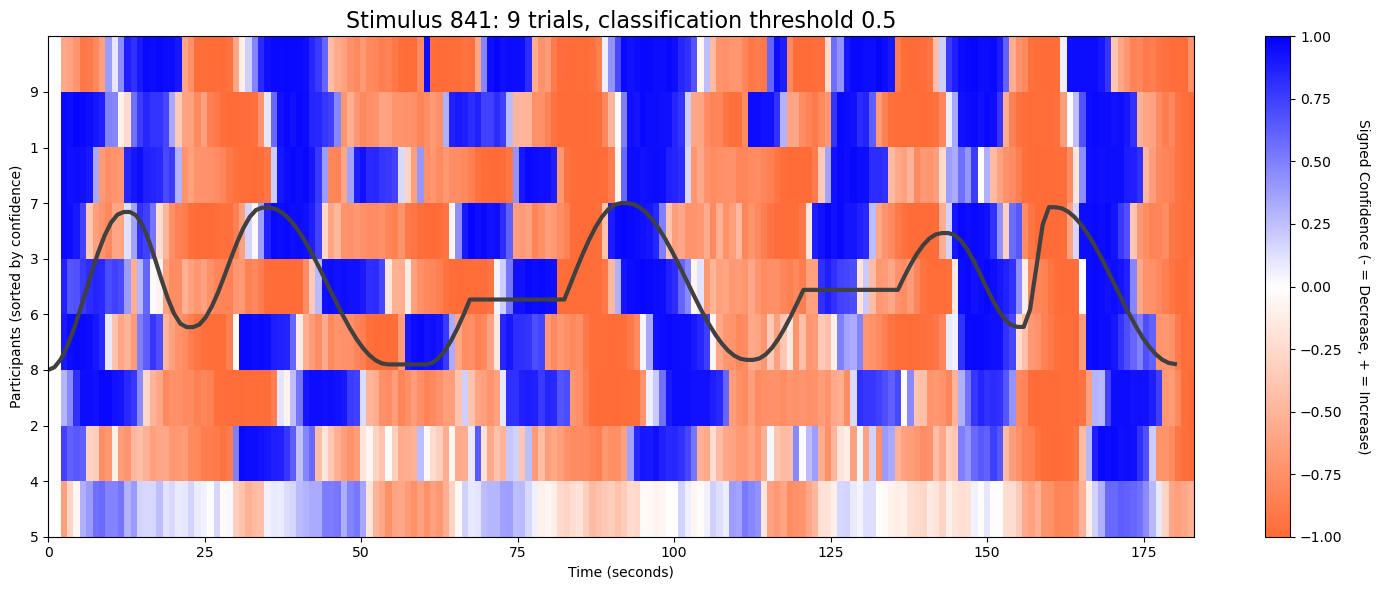

In [27]:
seed = 841
threshold = 0.5

plot_prediction_confidence_heatmap(
    probabilities=all_probabilities[seed],
    stimulus_seed=seed,
    classification_threshold=threshold,
    pseudonymize=True,
)


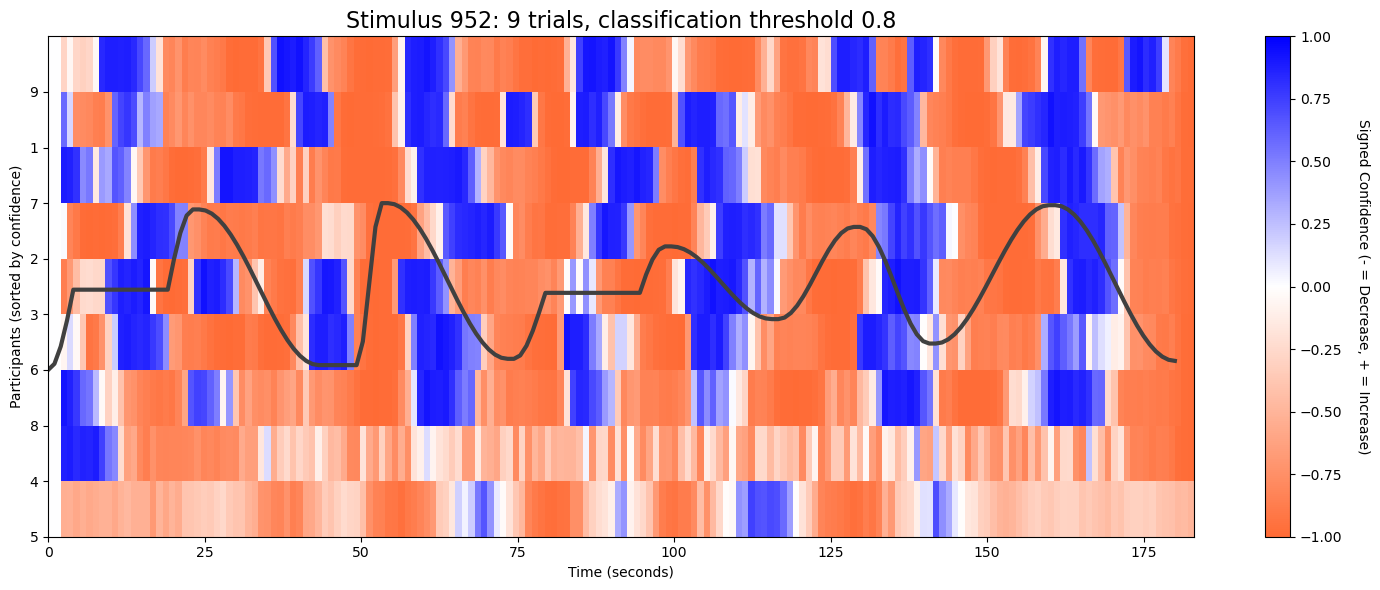

In [30]:
threshold = 0.8
plot_prediction_confidence_heatmap(
    probabilities=all_probabilities[seed],
    stimulus_seed=seed,
    classification_threshold=threshold,
    pseudonymize=True,
)

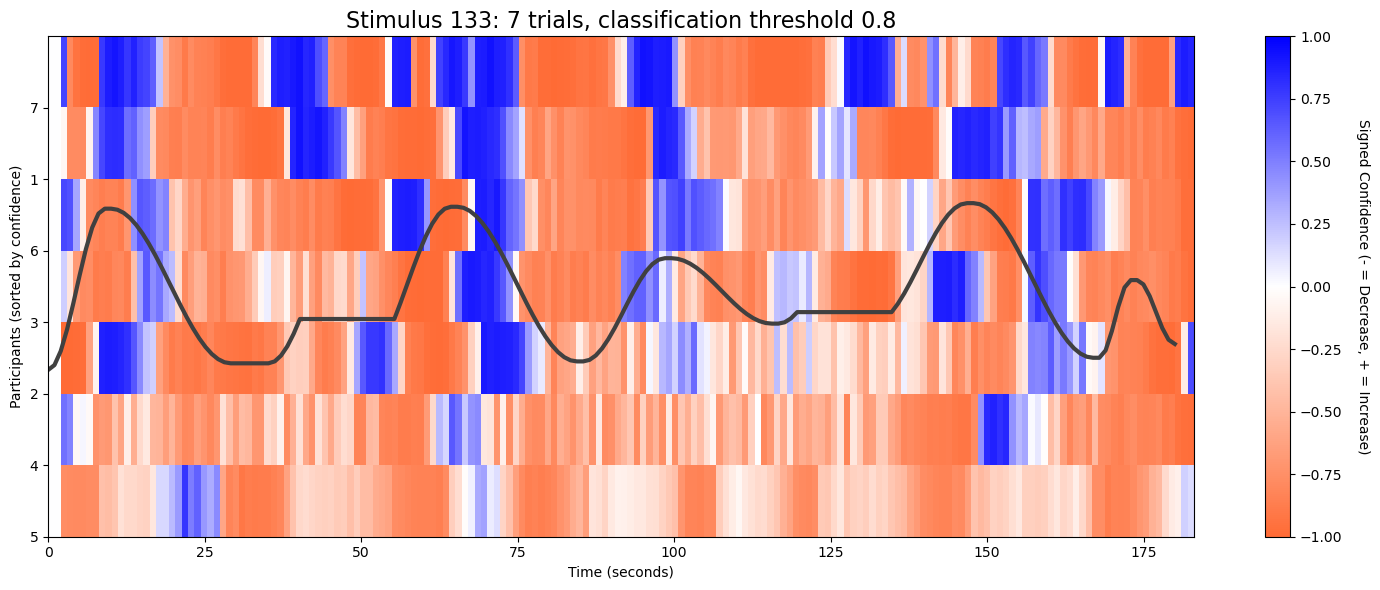

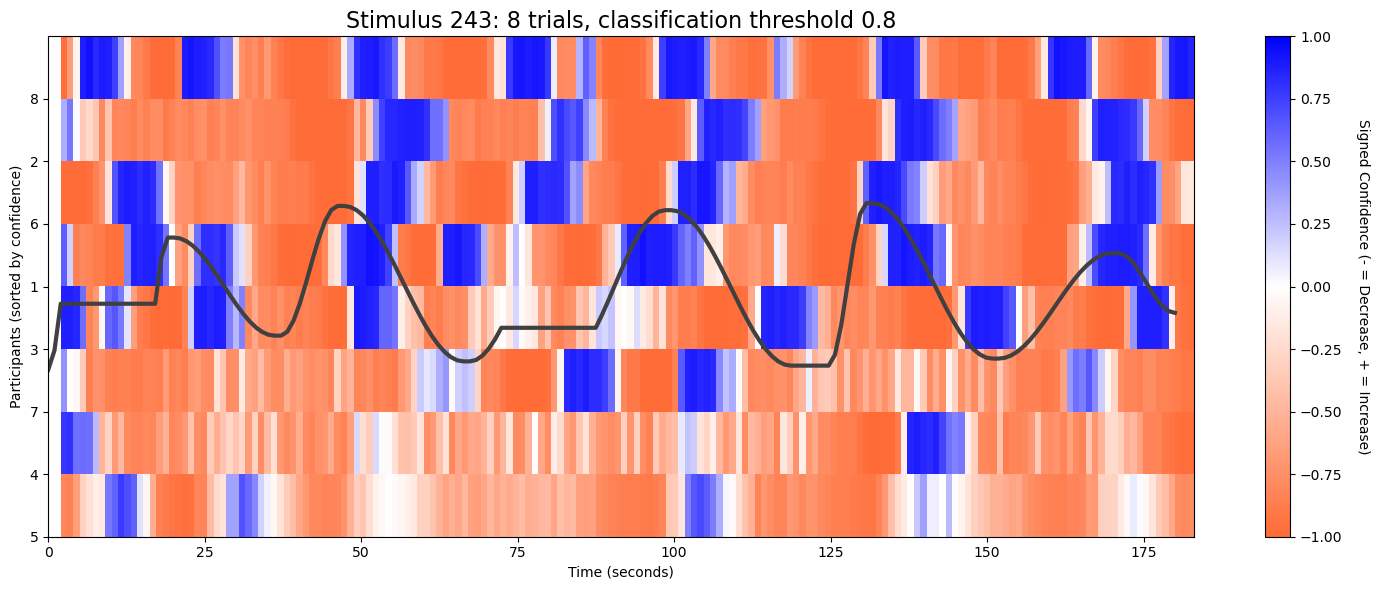

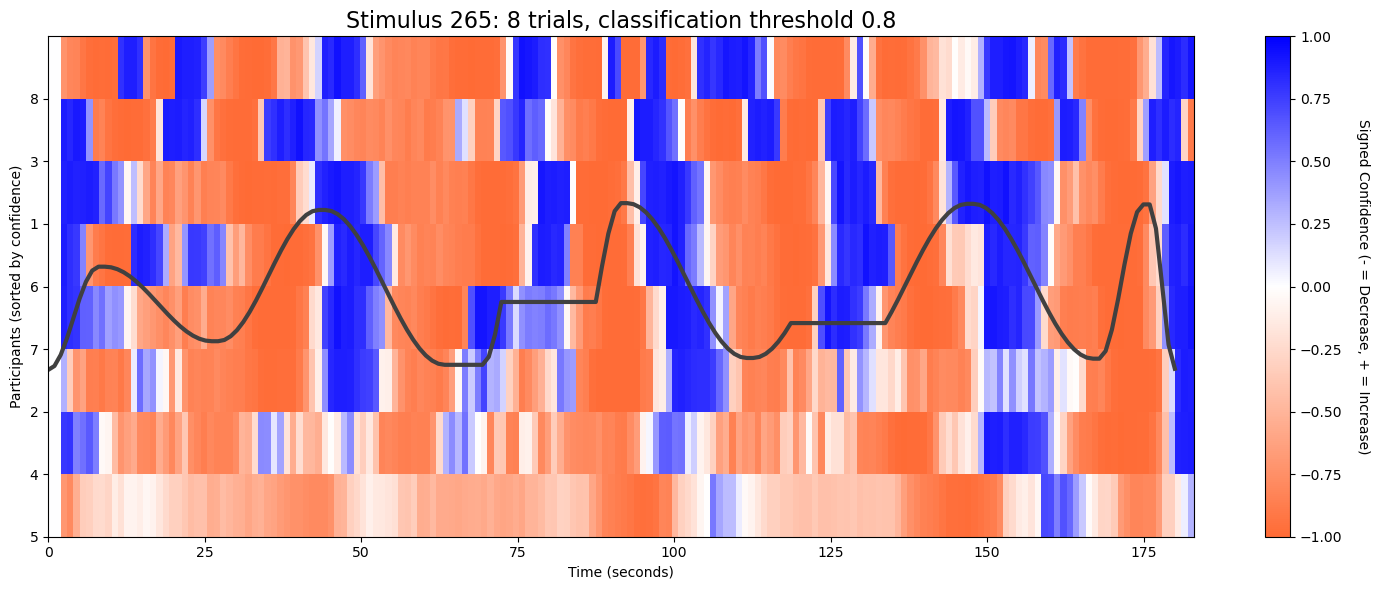

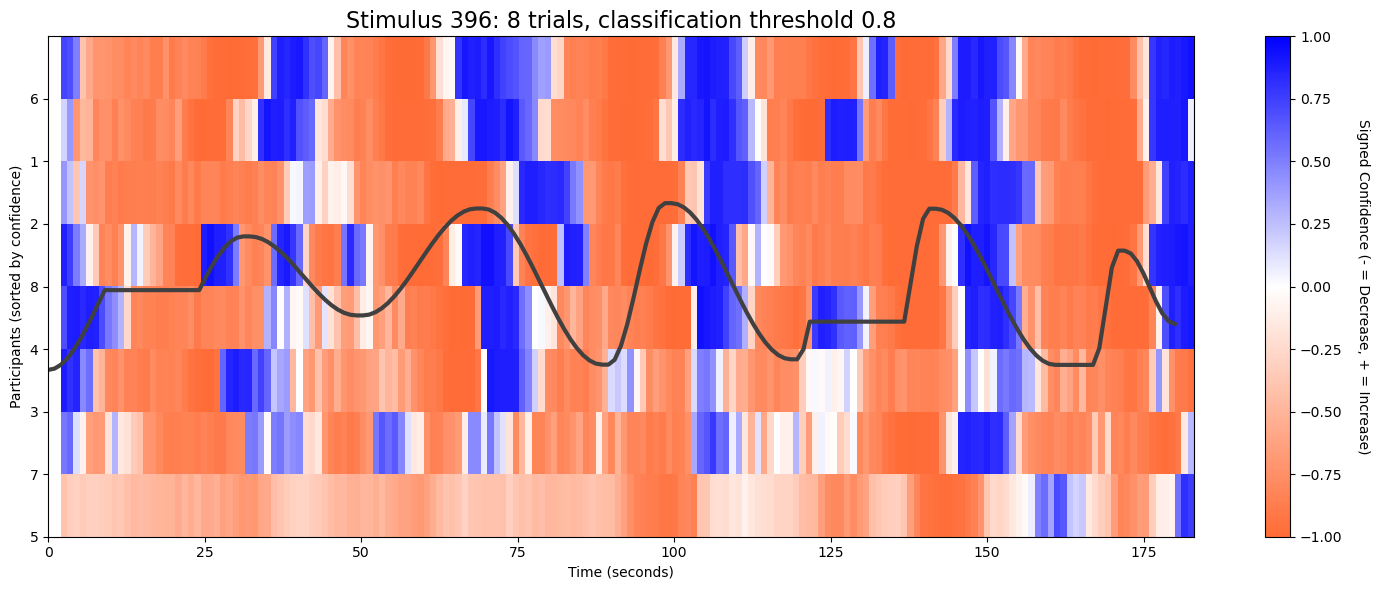

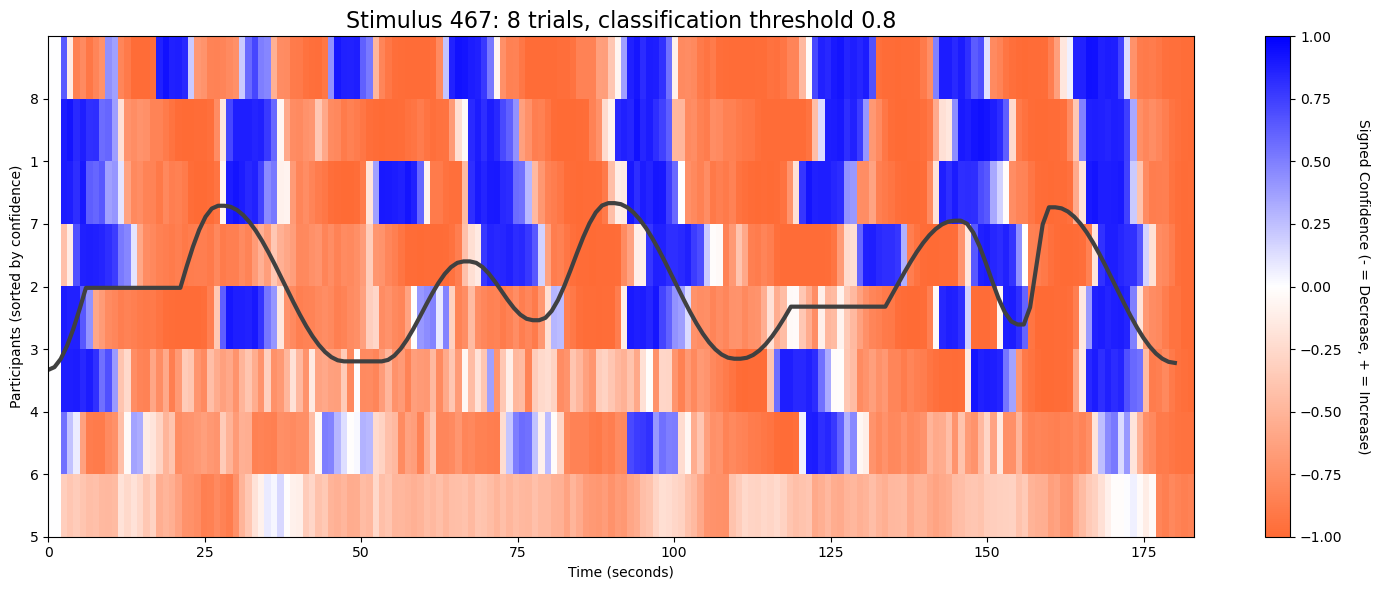

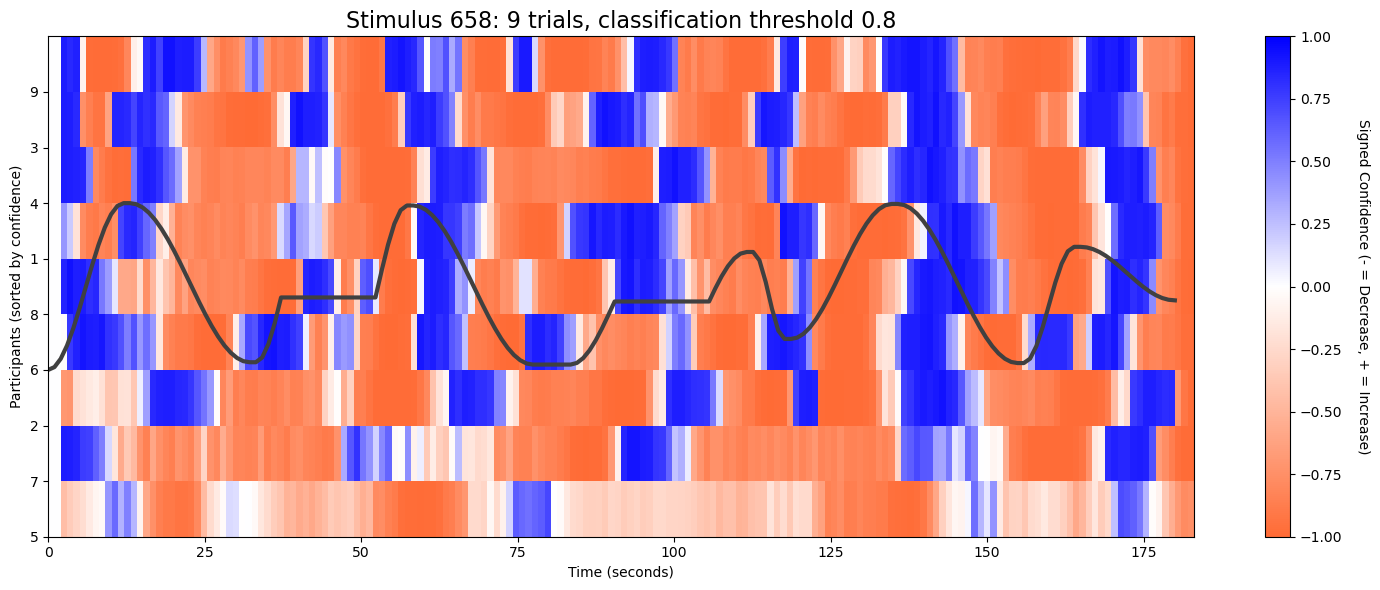

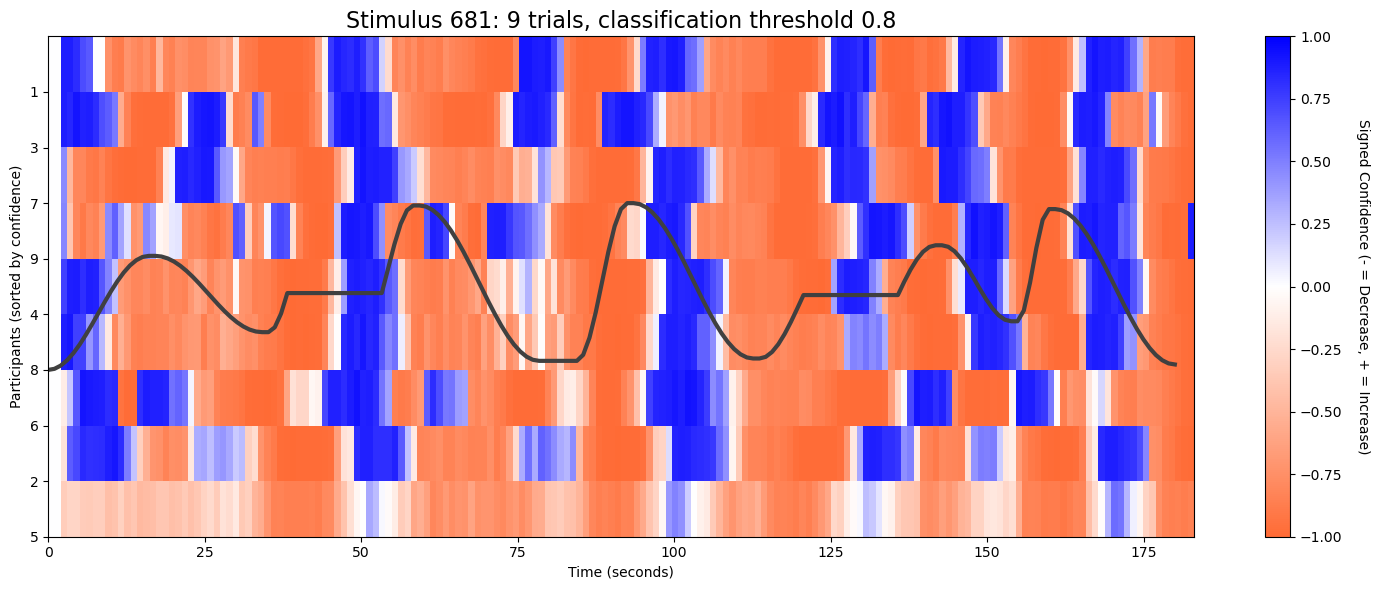

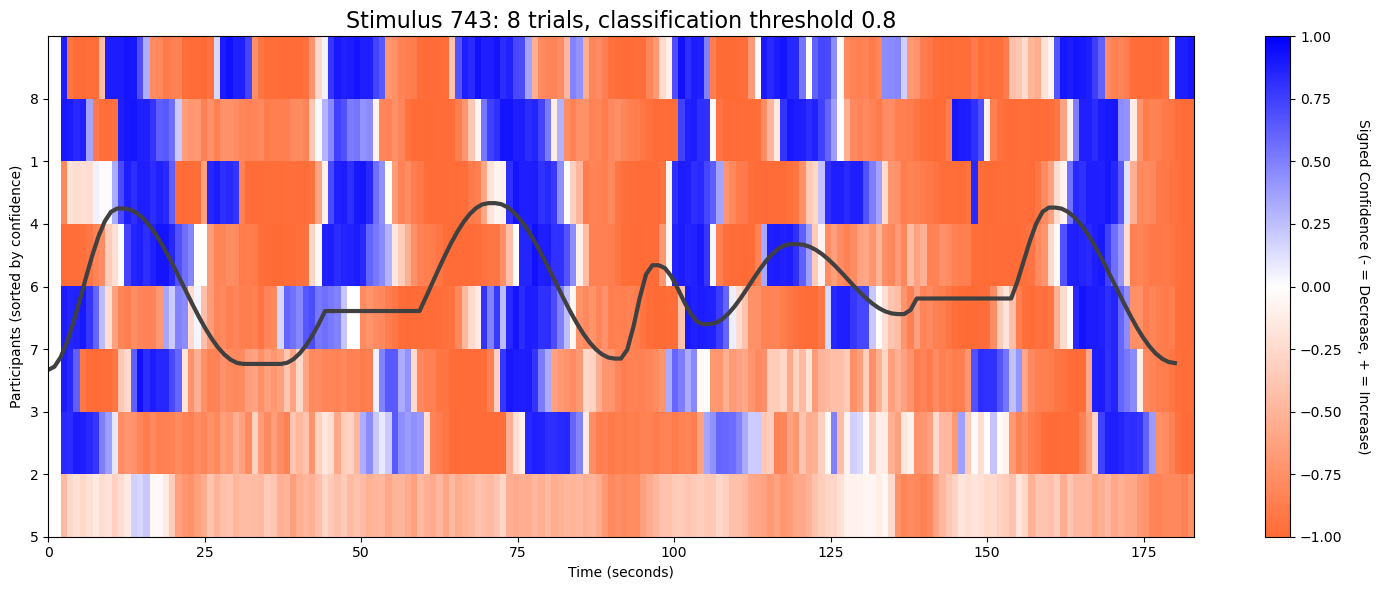

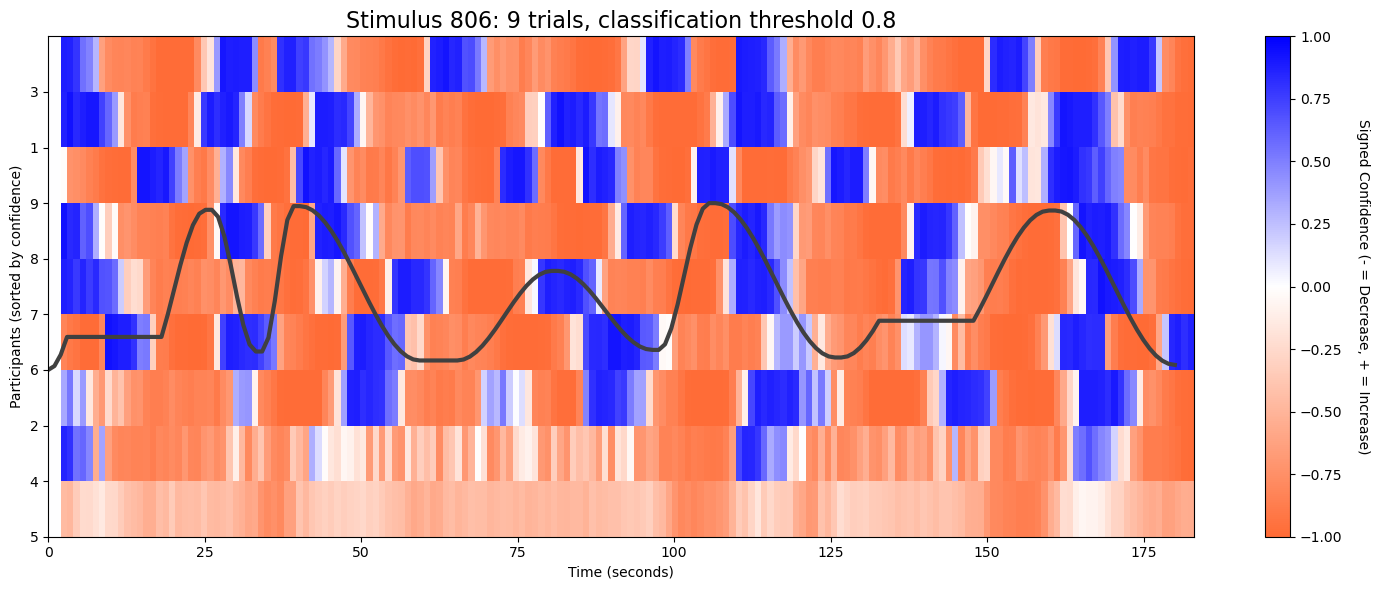

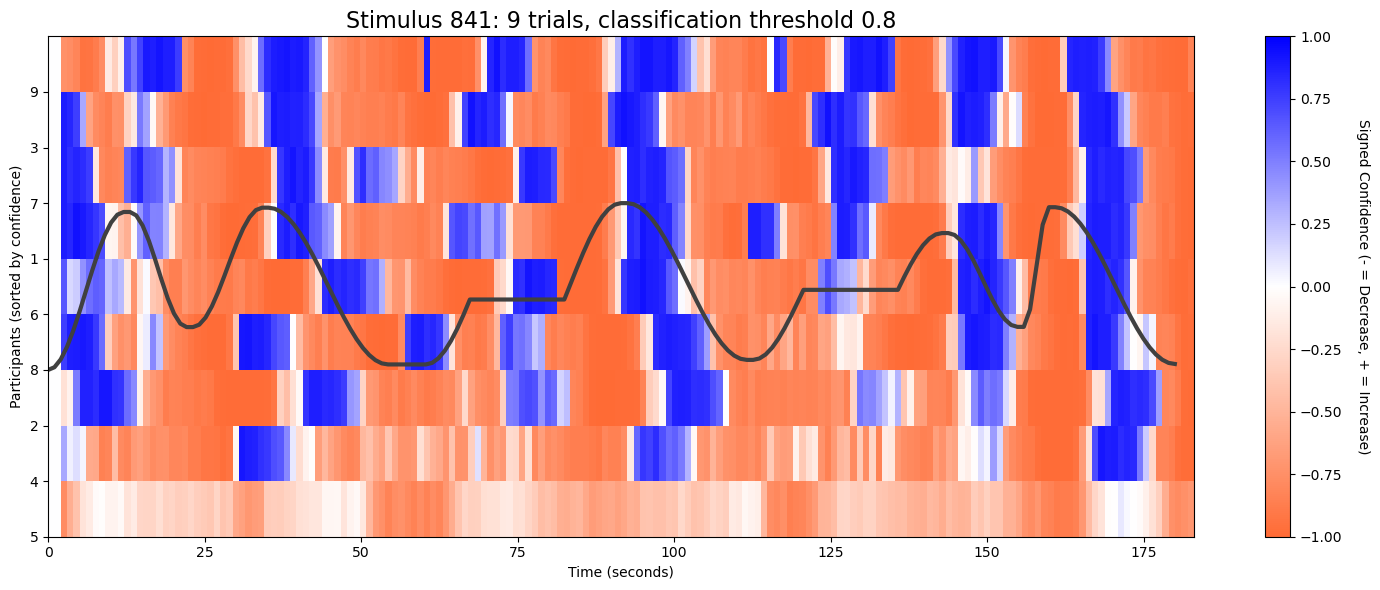

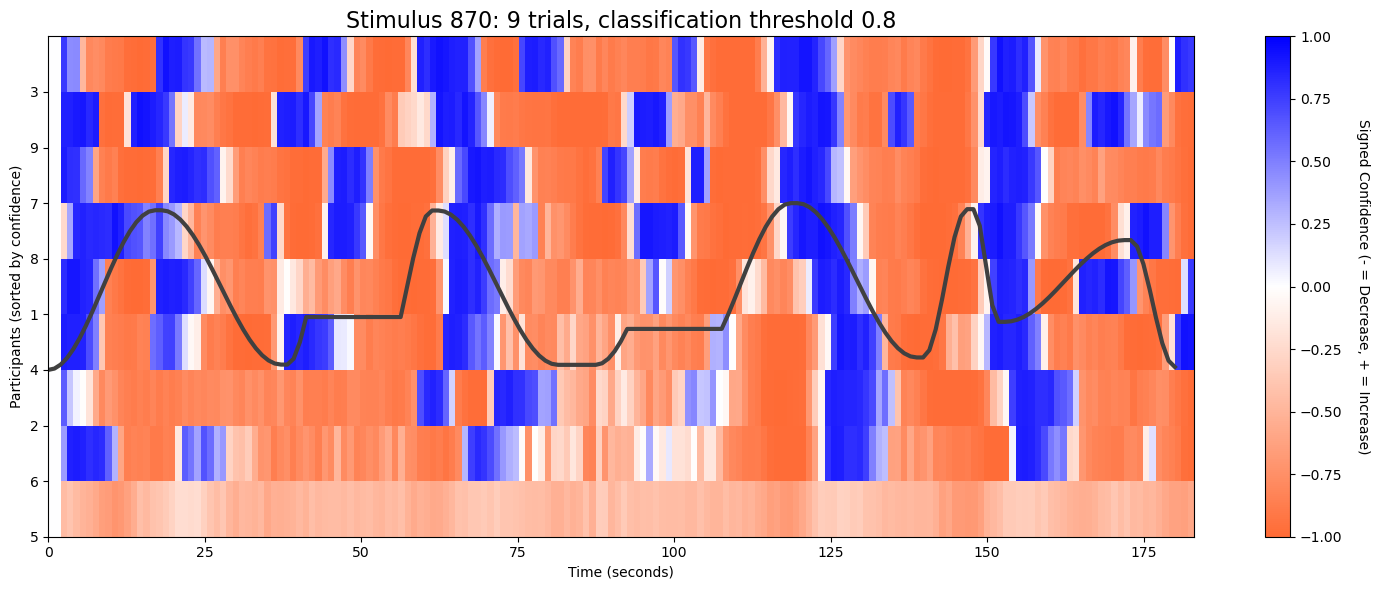

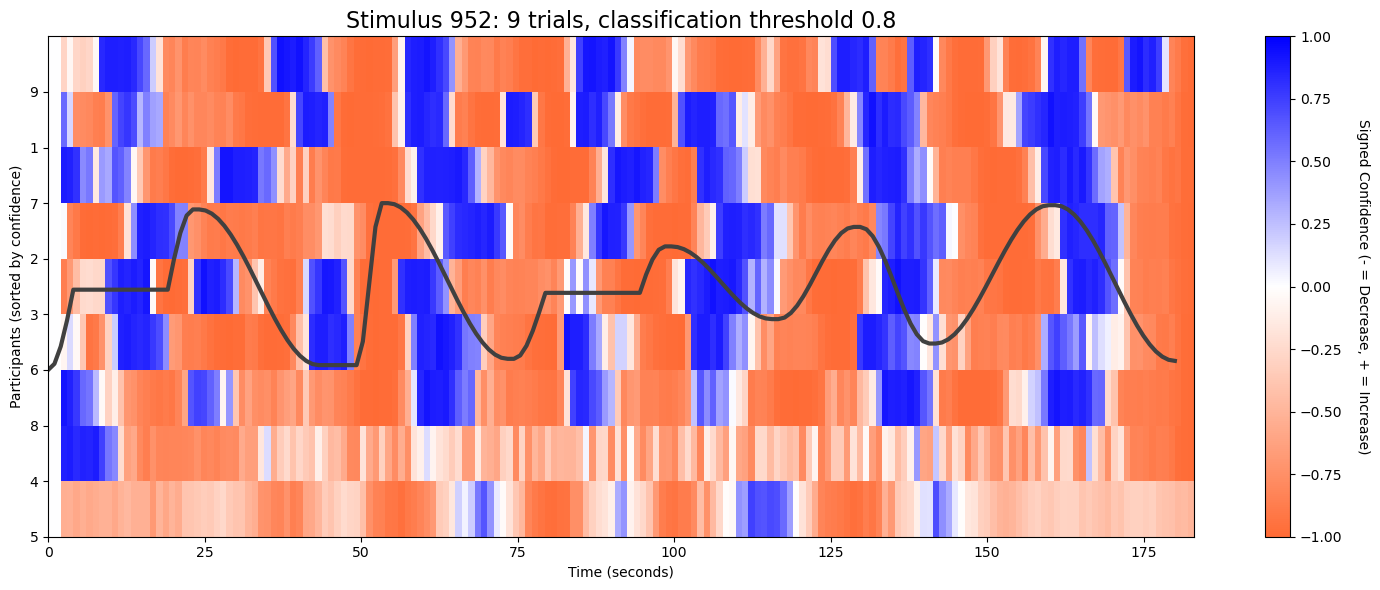

In [31]:
threshold = 0.8

for seed in seeds:
    # Create the visualization
    plot_prediction_confidence_heatmap(
        probabilities=all_probabilities[seed],
        stimulus_seed=seed,
        classification_threshold=threshold,
        pseudonymize=True,
    )